In [1]:
###loading
import numpy as np
import matplotlib.pyplot as plt


In [45]:
sig=np.load("./sig_toy_signal.npy")
sig.shape

(1000, 51840)

In [3]:
### Setting the time range
tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

In [4]:
from gaps_generation import ge_unsche

# unscheduled_gap=ge_unsche(t)



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,random_split

### Training set preparation

original_data = torch.from_numpy(sig)
original_data=original_data.unsqueeze(1)
print(original_data.size())

del sig

torch.Size([1000, 1, 51840])


In [6]:
### define dataset
class GenDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return sample


In [7]:
totaldata=GenDataset(original_data.float())
### Define the sizes of the training and test subsets
train_size = int(0.8 * len(totaldata))  # 80% for training
test_size = len(totaldata) - train_size  # Remaining 20% for testing
# Split the dataset randomly
n_train_dataset, n_test_dataset = random_split(totaldata, [train_size, test_size])

In [8]:
### Using dataloader in training
train_dataloader = DataLoader(n_train_dataset, batch_size=50)
test_dataloader = DataLoader(n_test_dataset , batch_size=50)

In [9]:
######################
#CAE import
######################
from DCAE import Autoencoder

# Create an instance of the autoencoder
autoencoder = Autoencoder()

# Print the autoencoder architecture
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(4,), padding=(2,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(8,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=103680, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4096, out_features=1024, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4096, out_features=103680, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=torch.Size([64, 1620]))
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), s

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.00001

### Set the random seed for reproducible results
torch.manual_seed(123)

optim = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-05)

In [11]:
# train round
total_train_step = 0
# test round
total_test_step = 0

epoch = 50
test_loss=np.zeros(50)

for i in range(epoch):
    print("--------the {} repoch ------".format(i+1))

    # train step
    autoencoder.train()  
    for data in train_dataloader:
        mask=ge_unsche(t)
        snodata,normaldata= autoencoder.signal_preprocess(data,mask)[:2]
        outputs=autoencoder(snodata)
        loss = loss_fn(outputs, normaldata)
        # Add L2 regularization for kernel weights
        l2_regularization = torch.tensor(0.)
        for param_name, param in autoencoder.named_parameters():
            if 'weight' in param_name and 'kernel' in param_name:
                l2_regularization += torch.norm(param)
        loss += l2_regularization * 0.001 # Add L2 regularization term

        # optimizer
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_train_step = total_train_step + 1
        if total_train_step % 8 == 0:
            print("train step：{}, loss:{}".format(total_train_step, loss.item()))

    # test
    autoencoder.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            mask=ge_unsche(t)
            snodata,normaldata= autoencoder.signal_preprocess(data,mask)[:2]
            outputs=autoencoder(snodata)
            loss = loss_fn(outputs, normaldata)

            total_test_loss = total_test_loss + loss.item()

    print("totel_test_Loss：{}".format(total_test_loss/4))
    test_loss[i]=total_test_loss
    total_test_step += 1



print("train+test done")

--------the 1 repoch ------
train step：8, loss:0.9999551773071289
train step：16, loss:0.9951039552688599
totel_test_Loss：0.9939705580472946
--------the 2 repoch ------
train step：24, loss:0.9804733991622925
train step：32, loss:0.9453780651092529
totel_test_Loss：0.9388284683227539
--------the 3 repoch ------
train step：40, loss:0.8829388618469238
train step：48, loss:0.80408775806427
totel_test_Loss：0.7951769083738327
--------the 4 repoch ------
train step：56, loss:0.7576261162757874
train step：64, loss:0.7082560062408447
totel_test_Loss：0.7018817812204361
--------the 5 repoch ------
train step：72, loss:0.6796261072158813
train step：80, loss:0.6474328637123108
totel_test_Loss：0.6422924846410751
--------the 6 repoch ------
train step：88, loss:0.6332582831382751
train step：96, loss:0.6112630367279053
totel_test_Loss：0.6074133366346359
--------the 7 repoch ------
train step：104, loss:0.606805145740509
train step：112, loss:0.5904284119606018
totel_test_Loss：0.5874716341495514
--------the 8 r

In [30]:
a_true = 4.5e-21
f_true = 1e-3+5e-7
fdot_true = 1e-8+5e-13
testsig=a_true *(np.sin((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))

In [38]:
a_true = 4.5e-21
f_true = 1e-3
fdot_true = 1e-8
testsig2=a_true *(np.sin((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))

In [31]:
unscheduled_gap=ge_unsche(t)
maskt=unscheduled_gap
testinput=torch.tensor(testsig.reshape((1,1,-1)))
snodata,normaldata,mean,std= autoencoder.signal_preprocess(testinput,maskt)
outputs=autoencoder(snodata)


In [32]:
recov=autoencoder.signal_backprocess(outputs,mean.unsqueeze(2),std.unsqueeze(2))
recov.size()

torch.Size([1, 1, 51840])

In [33]:
outputarr=recov.detach().numpy()
outputarr=outputarr.reshape((1,-1))

In [34]:
outputarr=outputs.detach().numpy()
outputarr=outputarr.reshape((1,-1))
testsigi=normaldata.detach().numpy()
testsigi=testsigi.reshape((1,-1))

In [35]:
cordata=testsig*maskt

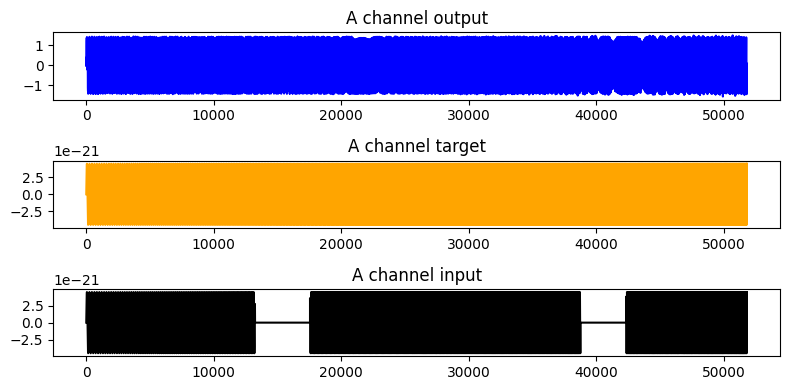

In [36]:

#plot
plt.rcParams["figure.figsize"] = (8,4)

# Create a figure and subplots
fig, axes = plt.subplots(3, 1)

# Plot on the first subplot
axes[0].plot(outputarr[0],c="b")
axes[0].set_title('A channel output')

# Plot on the second subplot
axes[1].plot(testsig,c="orange")
axes[1].set_title('A channel target')

# Plot on the second subplot
axes[2].plot(cordata,c="black")
axes[2].set_title('A channel input')


# Set the layout and display the figure
plt.tight_layout()
plt.show()

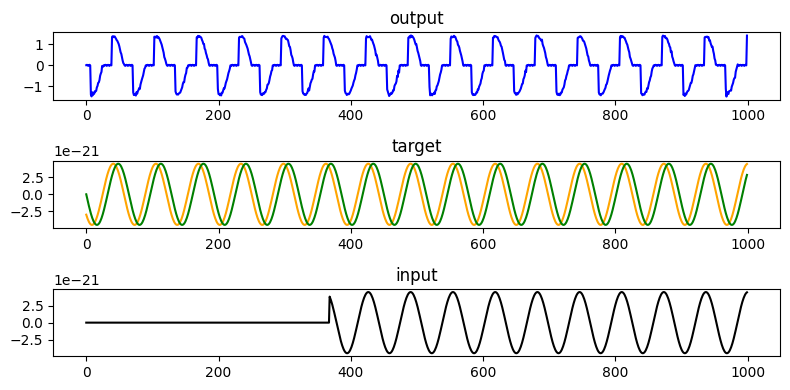

In [40]:

#plot
plt.rcParams["figure.figsize"] = (8,4)
x = np.linspace(0, 2000, 10000)

# Create a figure and subplots
fig, axes = plt.subplots(3, 1)
# y1 = np.ones_like(x)*1.5  # Array of ones with the same shape as x
# y2 = -np.ones_like(x)*1.5  # Array of negative ones with the same shape as x

# Plot on the first subplot
axes[0].plot(outputarr[0][42000:43000],c="b")
# axes[0].plot(x,y1,c="r")
# axes[0].plot(x,y2,c="r")
axes[0].set_title('output')

# Plot on the second subplot
axes[1].plot(testsig[42000:43000],c="orange")
axes[1].plot(testsig2[42000:43000],c="green")
axes[1].set_title('target')

# Plot on the second subplot
axes[2].plot(cordata[42000:43000],c="black")
axes[2].set_title('input')



# Set the layout and display the figure
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


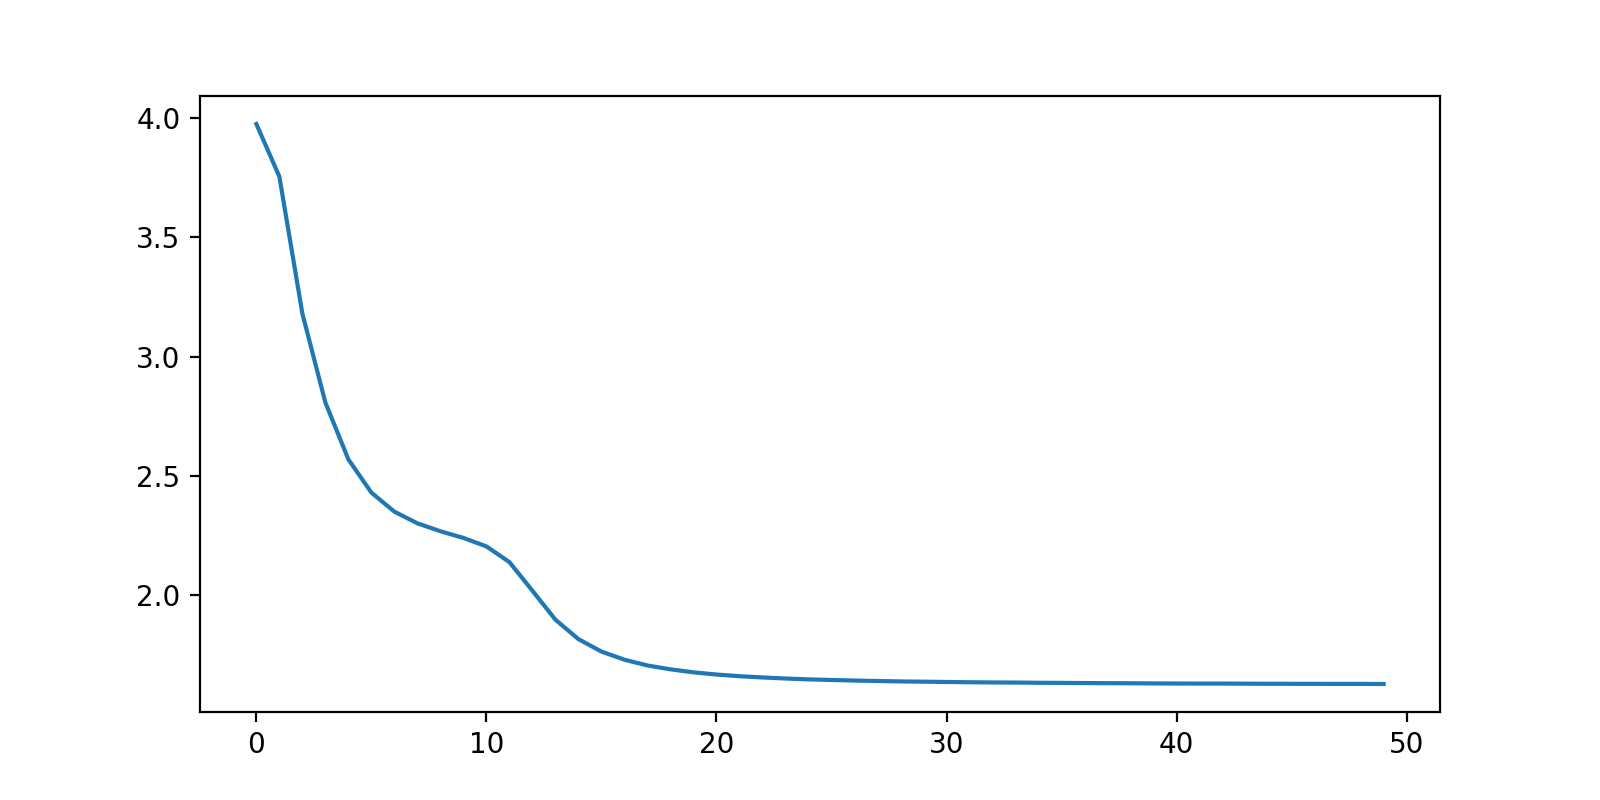

In [62]:
plt.plot(test_loss)

In [ ]:
torch.save(autoencoder, "./models_dcae.pth")
print("save model")

In [52]:
########
# get data ready for RNN training
########
#data for rnn
sigrnn=original_data[::5,:,:]
sigrnn.size()

torch.Size([200, 1, 51840])

In [55]:
sigrnn[1].reshape(1,1,-1).size()

torch.Size([1, 1, 51840])

In [57]:
inputrnn= np.zeros((200,51840))
targetrnn=np.zeros((200,51840))
for i in range(200):
    mask=ge_unsche(t)
    snodata0,normaldata0,mean0,std0= autoencoder.signal_preprocess(sigrnn[i].reshape(1,1,-1),mask)
    outputs0=autoencoder(snodata0)
    inputrnn0=outputs0.detach().numpy()
    inputrnn[i]=inputrnn0.reshape(1,-1)
    targetrnn0=normaldata0.detach().numpy()
    targetrnn[i]=targetrnn0.reshape(1,-1)
    

<IPython.core.display.Javascript object>


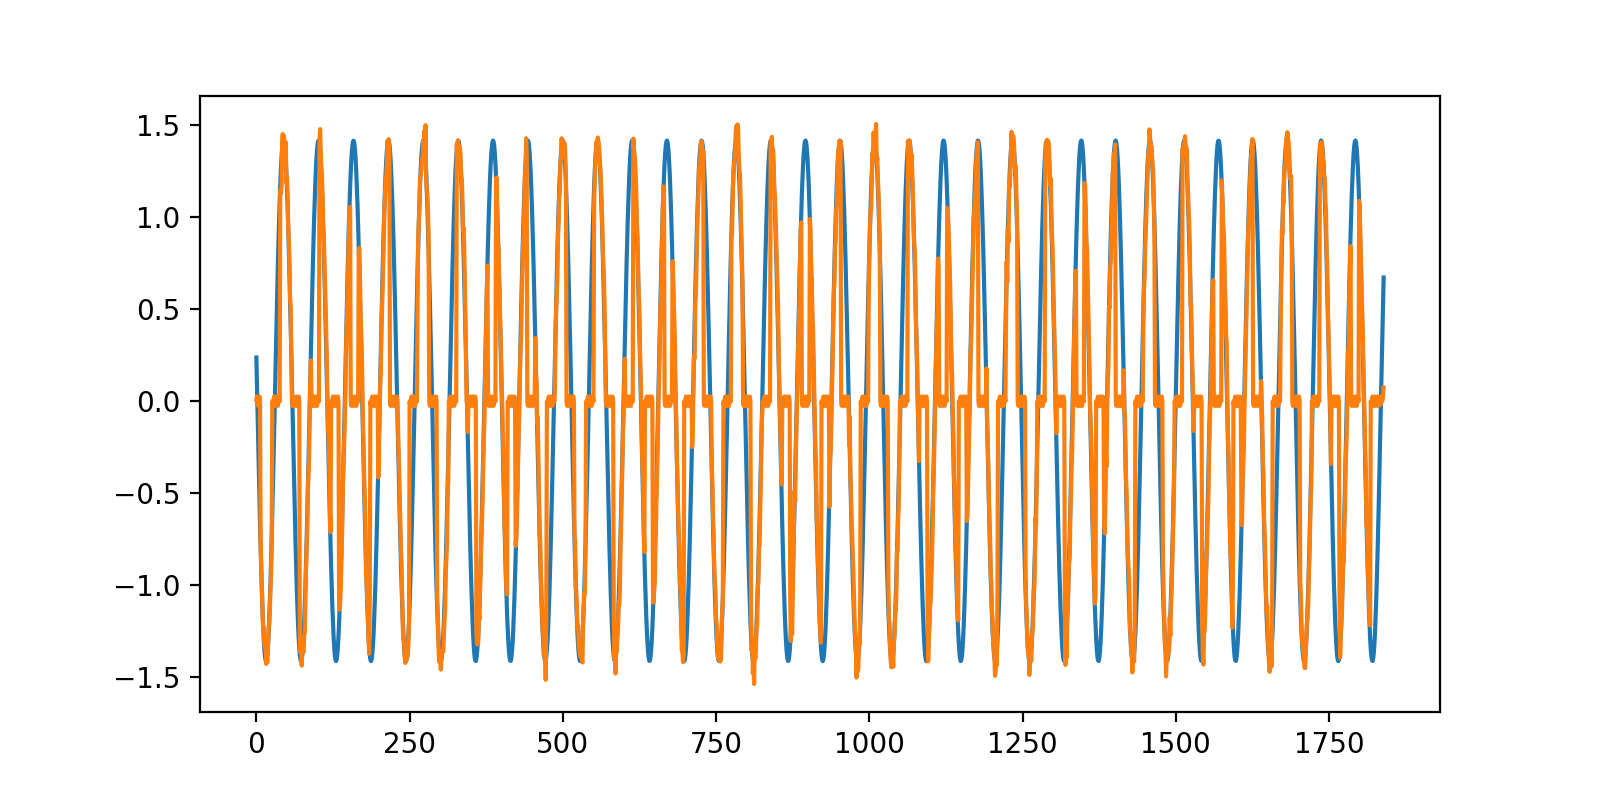

In [65]:
plt.plot(targetrnn[0,50000:])
plt.plot(inputrnn[0,50000:])

In [66]:
np.save("./inputrnn.npy",inputrnn)
np.save("./targetrnn.npy",targetrnn)